In [1]:
import numpy as np
from utils.slam_helpers import transform_to_frame,transformed_params2depthplussilhouette,transformed_params2rendervar,transformed_GRNparams2rendervar,transformed_GRNparams2depthplussilhouette
from diff_gaussian_rasterization import GaussianRasterizer as Renderer
from scripts.main_SurgeSplat import deform_gaussians, setup_camera
import torch
import os
from PIL import Image

System Paths:
/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM
/media/thesis_ssd/anaconda/envs/endogslam/lib/python310.zip
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/lib-dynload

/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages
/media/thesis_ssd/anaconda/envs/endogslam/lib/python3.10/site-packages/setuptools/_vendor
/tmp/tmp5_rlixis


In [2]:
intrinsics = torch.tensor([[199.6883,   0.0000, 166.3290],
        [  0.0000, 249.4753, 170.4058],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')
w2c = torch.tensor([[ 1.0000e+00,  6.5711e-11,  2.3283e-10,  0.0000e+00],
        [-3.1832e-11,  1.0000e+00, -7.4115e-21,  0.0000e+00],
        [-9.2644e-22,  2.9104e-11,  1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')

cam = setup_camera(336,336, intrinsics.cpu().numpy(), w2c.detach().cpu().numpy(), use_simplification=True)




In [3]:
exp = 1
params_np = np.load(f'experiments/EndoNerf pulling_deform_simple_33/pulling_deform_simple_33/params.npz',allow_pickle=True)
params={}
for key in params_np.keys():
    try:
        params[key] = torch.tensor(params_np[key]).cuda()
    except:
        params[key] = [torch.tensor(params_np[key][i]).cuda() for i in range(params_np[key].shape[0])]

In [4]:
params['means3D'][-1].shape

torch.Size([63826, 3])

In [5]:
def deform_gaussians(params, time, deform_grad, N=5,deformation_type = 'gaussian'):
    """
    Calculate deformations using the N closest basis functions based on |time - bias|.

    Args:
        params (dict): Dictionary containing deformation parameters.
        time (torch.Tensor): Current time step.
        deform_grad (bool): Whether to calculate gradients for deformations.
        N (int): Number of closest basis functions to consider.

    Returns:
        xyz (torch.Tensor): Updated 3D positions.
        rots (torch.Tensor): Updated rotations.
        scales (torch.Tensor): Updated scales.
    """
    if deformation_type =='gaussian':
        if True:
            if deform_grad:
                weights = params['deform_weights']
                stds = params['deform_stds']
                biases = params['deform_biases']
            else:
                weights = params['deform_weights'].detach()
                stds = params['deform_stds'].detach()
                biases = params['deform_biases'].detach()

            # Calculate the absolute difference between time and biases
            time_diff = torch.abs(time - biases)

            # Get the indices of the N smallest time differences
            _, top_indices = torch.topk(-time_diff, N, dim=1)  # Negative for smallest values

            # Create a mask to select only the top N basis functions
            mask = torch.zeros_like(time_diff, dtype=torch.float)
            mask.scatter_(1, top_indices, 1.0)

            # Apply the mask to weights and biases
            masked_weights = weights * mask
            masked_biases = biases * mask

            # Calculate deformations
            deform = torch.sum(
                masked_weights * torch.exp(-1 / (2 * stds**2) * (time - masked_biases)**2), dim=1
            )  # Nx10 gaussians deformations

            deform_xyz = deform[:, :3]
            deform_rots = deform[:, 3:7]
            deform_scales = deform[:, 7:10]
        else:
            if deform_grad:
                weights = params['deform_weights']
                stds = params['deform_stds']
                biases = params['deform_biases']
            else:
                weights = params['deform_weights'].detach()
                stds = params['deform_stds'].detach()
                biases = params['deform_biases'].detach()

            # Calculate the absolute difference between time and biases
            time_diff = torch.abs(time - biases)

            # Get the indices of the N smallest time differences
            _, top_indices = torch.topk(-time_diff, N, dim=1)  # Negative for smallest values

            # Create a mask to select only the top N basis functions
            mask = torch.zeros_like(time_diff, dtype=torch.float)
            mask.scatter_(1, top_indices, 1.0).detach()

            # Register a gradient hook to zero out gradients for irrelevant basis functions
            if deform_grad:
                def zero_out_irrelevant_gradients(grad):
                    return grad * mask

                weights.register_hook(zero_out_irrelevant_gradients)
                biases.register_hook(zero_out_irrelevant_gradients)
                stds.register_hook(zero_out_irrelevant_gradients)

            # Calculate deformations
            deform = torch.sum(
                weights * torch.exp(-1 / (2 * stds**2) * (time - biases)**2), dim=1
            )  # Nx10 gaussians deformations

            deform_xyz = deform[:, :3]
            deform_rots = deform[:, 3:7]
            deform_scales = deform[:, 7:10]

        xyz = params['means3D'] + deform_xyz
        rots = params['unnorm_rotations'] + deform_rots
        scales = params['log_scales'] + deform_scales
        opacities = params['logit_opacities']
        colors = params['rgb_colors']


    elif deformation_type == 'simple':
        # with torch.no_grad():
        xyz = params['means3D'][time]
        rots = params['unnorm_rotations'][time]
        scales = params['log_scales'][time]
        opacities = params['logit_opacities'][time]
        colors = params['rgb_colors'][time]

    return xyz, rots, scales,opacities, colors
for i in range(params['cam_trans'].shape[-1]):
    params['cam_trans'][...,i][...,-1] += 0

for id in range(params['cam_unnorm_rots'].shape[-1]):
    local_means,local_rots,local_scales,local_opacities,local_colors = deform_gaussians(params,id,deform_grad = True,deformation_type='simple')


    #  print(torch.sum(local_means-params['means3D']))

    transformed_pts = transform_to_frame(local_means,params,id,False,False)





    # Initialize Render Variables
    rendervar = transformed_GRNparams2rendervar(params, transformed_pts,local_rots,local_scales,local_opacities,local_colors)
    print(local_scales.max())
    rv_store = {}
    for key in rendervar.keys():
        rv_store[key] = rendervar[key].cpu().detach()
        local_means_store = local_means.cpu()
        local_scales_store = local_rots.cpu()
        local_rots_store = local_rots.cpu()
        transformed_pts_store = transformed_pts.cpu()



    #  rendervar['means3D'].retain_grad()

    depth_sil_rendervar = transformed_GRNparams2depthplussilhouette(params, w2c,
                                            transformed_pts,local_rots,local_scales,local_opacities)


    #RGB Rendering

    rendervar['means2D'].retain_grad()
    im, radius, _ = Renderer(raster_settings=cam)(**rendervar)
    # variables['means2D'] = rendervar['means2D'] # Gradient only accum from colour render for densification
    img = Image.fromarray((im.permute(1,2,0).cpu().detach().numpy()*255).astype(np.uint8))
    os.makedirs(f'./eval_plots/plots_simple/',exist_ok=True)
    img.save(f'./eval_plots/plots_simple/{id}.png')

    print(local_means.shape)


tensor(0.8758, device='cuda:0')
torch.Size([55999, 3])
tensor(0.8758, device='cuda:0')
torch.Size([55999, 3])
tensor(0.8938, device='cuda:0')
torch.Size([56292, 3])
tensor(0.9483, device='cuda:0')
torch.Size([56371, 3])
tensor(0.9986, device='cuda:0')
torch.Size([56508, 3])
tensor(1.0378, device='cuda:0')
torch.Size([56609, 3])
tensor(1.0842, device='cuda:0')
torch.Size([56897, 3])
tensor(1.1125, device='cuda:0')
torch.Size([57171, 3])
tensor(1.1125, device='cuda:0')
torch.Size([57171, 3])
tensor(1.1584, device='cuda:0')
torch.Size([57594, 3])
tensor(1.2129, device='cuda:0')
torch.Size([57905, 3])
tensor(1.2544, device='cuda:0')
torch.Size([58268, 3])
tensor(1.2026, device='cuda:0')
torch.Size([58502, 3])
tensor(1.1910, device='cuda:0')
torch.Size([58730, 3])
tensor(1.2232, device='cuda:0')
torch.Size([58812, 3])
tensor(1.2449, device='cuda:0')
torch.Size([58875, 3])
tensor(1.2449, device='cuda:0')
torch.Size([58875, 3])
tensor(1.2947, device='cuda:0')
torch.Size([59061, 3])
tensor(1.3

In [6]:
params['cam_trans'].shape

torch.Size([1, 3, 63])

In [7]:
# import matplotlib.pyplot as plt
# weights =   params['deform_weights'].cpu().detach()
# biases =    params['deform_biases'].cpu().detach()
# stds =      params['deform_stds'].cpu().detach()

# deforms = []
# deformsx1 = []
# for time in range(100):
#     deform = torch.sum(weights*torch.exp(-1/(2*stds**2)*(time-biases)**2),1)
#     deforms.append(deform) # Nx10 gaussians deformations
#     deformsx1.append(deform[0,0])
# fig,ax = plt.subplots(10,10,figsize = (25,25),sharey=True)
# for i in range(10):
#     for ii in range(10):
#         ax[ii,i].plot([deforms[idx][i+91720//3,ii] for idx in range(len(deforms))])
#         ax[ii,i].axhline(y = 0.0,color = 'r', linestyle = '--')    

In [8]:
# from GRN.models.conv_unet import GaussianRegressionNetwork
# import torch

# state_dict = torch.load('logs/GRN_6/checkpoint.pth',weights_only=False)
# model_state_dict = state_dict['model']

# model = GaussianRegressionNetwork()
# # model.load_state_dict(model_state_dict)

# torch.save(model.state_dict(),'GRN/models/GRN_v1.pth')


In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# depth = np.load('/media/thesis_ssd/data/Endonerf/cutting_tissues_twice-20241203T074853Z-001/cutting_tissues_twice/depth/depth_frame-000000.npz')
# depth = depth['data']
# plt.imshow(depth)
# plt.colorbar()

In [10]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# image_paths = os.listdir('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/RARP/frames/')
# # image_paths = image_paths[:2]
# for image_path in image_paths:
#     image = cv2.imread(os.path.join('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/RARP/frames/', image_path))
#     # Convert to grayscale
#     image_cropped = image[75:-75, 300:-300]

#     cv2.imwrite(os.path.join('/media/thesis_ssd/code/EndoGSLAM/EndoGSLAM/data/RARP/frames', f'cropped_{image_path}'), image_cropped)


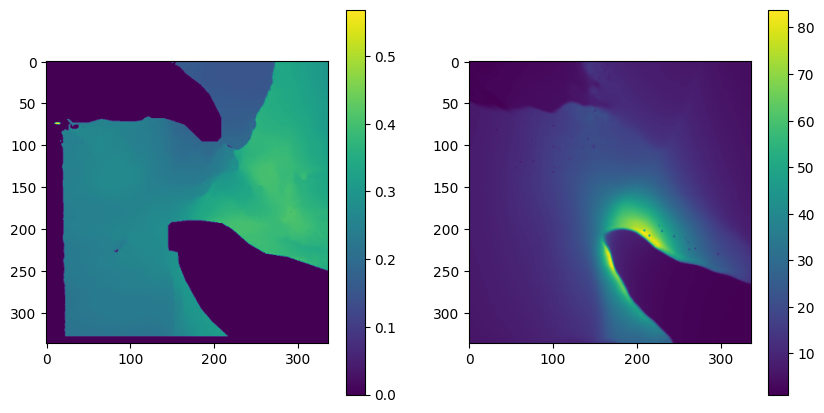

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
# gt_depth = np.load('/media/thesis_ssd/data/Endonerf/pulling_soft_tissues-20241203T074946Z-001/pulling_soft_tissues/depth/depth_frame-000062.npz')
# gt_depth = gt_depth['data']
gt_depth = cv2.imread('/media/thesis_ssd/data/Endonerf/pulling_soft_tissues-20241203T074946Z-001/pulling_soft_tissues/depth/frame-000062.depth.png', cv2.IMREAD_GRAYSCALE)
gt_depth = cv2.resize(gt_depth, (336, 336))
gt_depth = torch.tensor(gt_depth).unsqueeze(0)/255.0
predicted_depth,_,_ = Renderer(raster_settings=cam)(**depth_sil_rendervar)
predicted_depth = predicted_depth[0,:,:].unsqueeze(0).cpu().detach()


fig,ax = plt.subplots(1,2,figsize=(10,5))
im0 = ax[0].imshow(gt_depth.squeeze())
im1 = ax[1].imshow(predicted_depth.squeeze().cpu().detach().numpy())
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()

In [71]:
from utils.slam_helpers import align_shift_and_scale
import torch
mask = gt_depth>0.0

_,_,t_gt,s_gt,t_pred,s_pred = align_shift_and_scale(gt_depth,predicted_depth,mask)
gt_aligned = gt_depth
pred_aligned = (predicted_depth-t_pred)*(s_gt/s_pred)+t_gt

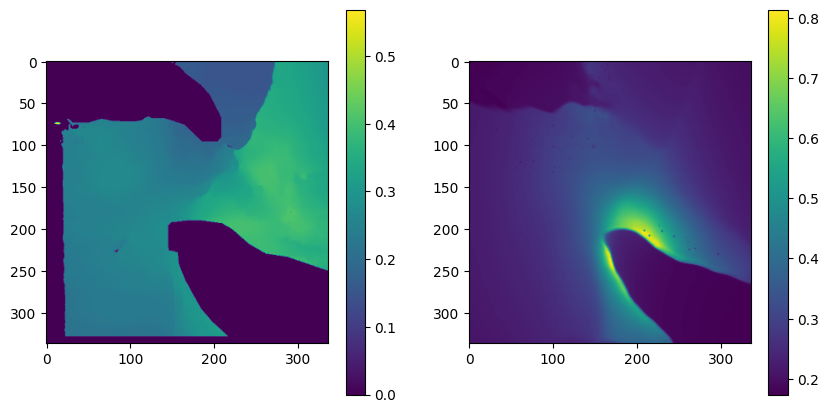

In [72]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
im0 = ax[0].imshow((gt_aligned).squeeze().cpu().detach())
im1 = ax[1].imshow(pred_aligned.squeeze().cpu().detach().numpy())

plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()

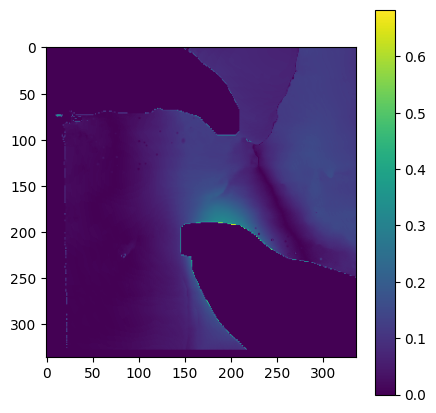

In [73]:
diff = torch.abs(gt_aligned-pred_aligned)*mask
fig,ax = plt.subplots(1,1,figsize=(5,5))
im0 = ax.imshow((diff).squeeze().cpu().detach().numpy())
plt.colorbar(im0, ax=ax)
plt.show()

In [74]:
abs_rel = torch.mean(torch.abs(gt_depth[mask]-pred_aligned[mask])/gt_depth[mask])
abs_rel

tensor(0.3205)

In [1]:
a = {'a1':0.1, 'a2':0.2, 'a3':0.3}
list = [a for i in range(5)]
errors_np = {key: [] for key in list[0].keys()}
for error in list:
    for key in error.keys():
        errors_np[key].append(error[key])

In [2]:
errors_np

{'a1': [0.1, 0.1, 0.1, 0.1, 0.1],
 'a2': [0.2, 0.2, 0.2, 0.2, 0.2],
 'a3': [0.3, 0.3, 0.3, 0.3, 0.3]}

In [3]:
import numpy as np


np.savetxt('errors.txt', np.array(errors_np['a1'],errors_np['a2']))

TypeError: Field elements must be 2- or 3-tuples, got '0.2'

In [ ]:
a = {'abs_rel':0.1, 'sq_rel':0.2, 'RMSE_log':0.3}
list = [a for i in range(5)]
errors_np = {key: [] for key in list[0].keys()}
for error in list:
    for key in error.keys():
        errors_np[key].append(error[key])
np.savetxt('errors.txt',np.array([errors_np[key] for key in errors_np.keys()]).T,header = '     '.join(errors_np.keys()), fmt='%.6f',delimiter= ',     ')

In [35]:
'       '.join(errors_np.keys())

'a1       a2       a3'